In [1]:
import os
import sys
import numpy as np
import pandas as pd
from pathlib import Path
import scipy.signal as signal
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import importlib
from fileorganize import dir_to_df
from sklearn.linear_model import LogisticRegression

cwd = os.getcwd()
sys.path.insert(0, os.path.abspath(os.path.dirname(cwd)))

import phonlab as phon

importlib.reload(phon)

print(phon.__name__,phon.__version__)


phonlab 0.0.24


In [2]:
mandarin = Path(
    '/Volumes/WDBook/Corpora/asc/corpus'
)

# get a dataframe listing all of the TextGrid files in the database
tgdf = dir_to_df(mandarin, fnpat=r"(?P<gender>[mf]).+.TextGrid$", addcols=['barename'])
print(f'Found {len(tgdf)} TextGrid files.')

tgdf

Found 780 TextGrid files.


,relpath,fname,barename,gender
0,f001,f001001_01.TextGrid,f001001_01,f
1,f001,f001001_02.TextGrid,f001001_02,f
2,f001,f001001_03.TextGrid,f001001_03,f
3,f001,f001001_04.TextGrid,f001001_04,f
4,f001,f001001_05.TextGrid,f001001_05,f
...,...,...,...,...
775,m005,m005017_06.TextGrid,m005017_06,m
776,m005,m005018_01.TextGrid,m005018_01,m
777,m005,m005018_02.TextGrid,m005018_02,m
778,m005,m005018_03.TextGrid,m005018_03,m


In [14]:
speaker=""
rng = np.random.default_rng()

bigdf = pd.DataFrame()

for row in tgdf.itertuples():   # loop through all of the label files
    if rng.random()<0.75:  # to speed things up we'll just take 25% of the corpus
        continue           # this is still over a million frames of data
    
    if speaker != row.relpath:
        speaker = row.relpath
        print(f"{speaker}")   


    wav = f'{row.barename}.wav'
    wavname = str(mandarin / row.relpath / wav)  # construct the name of the wav file

    if row.gender == 'm':
        f0_range = [60,400]
    else:
        f0_range = [60,400]

    audio,egg,fs = phon.loadsig(wavname, chansel=[0,1])
    f0df = phon.get_f0_acd(audio,fs,f0_range=f0_range)
    eggdf = phon.egg_to_oq(egg,fs,f0_range=f0_range)
    f0df['vuv'] = 'uv'
    f0df['vuv'] = f0df['vuv'].where(np.isnan(eggdf.OQ), 'v')
    f0df['file'] = wav

    if bigdf.empty:
        bigdf = f0df
    else:
        bigdf = pd.concat([bigdf,f0df],ignore_index=True)


bigdf.head()

f001
f002
f003
f004
f005
m001
m002
m003
m004
m005


,sec,f0,rms,h1h2,c,vuv,file
0,0.020,NaN,-78.326584,NaN,5.0,uv,f001001_02.wav
1,0.025,NaN,-78.736023,NaN,5.0,uv,f001001_02.wav
2,0.030,NaN,-79.222183,NaN,5.0,uv,f001001_02.wav
3,0.035,NaN,-79.419952,NaN,5.0,uv,f001001_02.wav
4,0.040,NaN,-79.665245,NaN,5.0,uv,f001001_02.wav


In [15]:
print(f"N = {len(bigdf)}")
print(bigdf.groupby('vuv').c.mean())
print(bigdf.groupby('vuv').rms.mean())

test_data = bigdf.groupby('vuv').sample(10000,replace=True)
test_data.head()

N = 1092985
vuv
uv    3.957919
v     2.377676
Name: c, dtype: float64
vuv
uv   -65.792664
v    -36.517231
Name: rms, dtype: float32


,sec,f0,rms,h1h2,c,vuv,file
685382,15.610,NaN,-47.315582,NaN,5.00,uv,m002003_01.wav
852111,22.875,NaN,-81.557251,NaN,5.00,uv,m003012_05.wav
964086,1.915,150.140625,-86.711838,-9.419617,3.25,uv,m004012_02.wav
473016,33.070,NaN,-76.890121,NaN,5.00,uv,f005006_01.wav
893666,31.355,78.393229,-50.484177,-9.763634,2.40,uv,m004004_01.wav


<Axes: xlabel='c', ylabel='rms'>

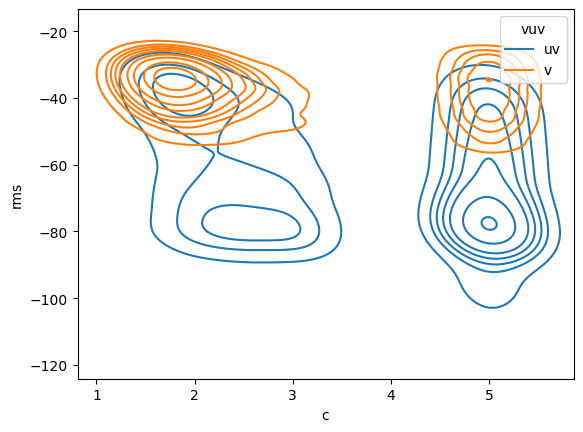

In [16]:
sns.kdeplot(test_data,y='rms',x="c",hue=("vuv"))

In [18]:
def warn(*args, **kwargs):   # this is a hack to avoid getting so many printed warning messages
    pass
warnings.warn = warn

# select a test set randomly - no priors, each phone is equally likely
test_data = bigdf.dropna().groupby('vuv').sample(500000,replace=True)

X = test_data[['rms','c']].to_numpy()
lm = LogisticRegression(class_weight='balanced').fit(X,test_data["vuv"])
score = lm.score(X,test_data['vuv'])

print(score)
print(f"model is:  {lm.intercept_[0]:3.2f} + {lm.coef_[0,0]:3.2f}*rms + {lm.coef_[0,1]:3.2f}*c")
#print(f"model is:  {lm.intercept_[0]:3.2f} + {lm.coef_[0,0]:3.2f}*c")

0.838959
model is:  8.65 + 0.16*rms + -0.83*c
